In [27]:
import re
import uuid
from typing_extensions import Literal, Annotated
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
    RemoveMessage
)
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langchain_core.runnables import RunnableConfig
from langgraph.graph.message import MessagesState, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.types import Command
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
llm = ChatOpenAI(
  model="gpt-4o-mini",
  temperature=0.0,
  base_url="https://openai.vocareum.com/v1"
)

## 1 - Create the State Schema

In [29]:
class SessionState(MessagesState):
  customer_query: str
  negotiation_status: Literal["won", "lost", "in_progress"]

## 2 - Define Entrypoint node

In [30]:
def summarize_conversation(messages) -> AIMessage:
  # All but system message
  messages_to_summarize = messages[1:-1]
  summary_message = HumanMessage(
    content="Create a summary of the conversation above:",
  )
  ai_message = llm.invoke(
    add_messages(
      messages_to_summarize,
      summary_message
    )
  )
  ai_message.id = str(uuid.uuid4())
  return ai_message

In [31]:
def entry_point(state: SessionState, config: RunnableConfig):
  messages = state["messages"]
  customer_name = config.get("configurable", {}).get("customer_name", "customer")
  age = config.get("configurable", {}).get("age", 18)
  income = config.get("configurable", {}).get("income", 1000)
  credit_score = config.get("configurable", {}).get("credit_score", 500)
  if not messages:
    prompt = (
      "You are a Loan Agent analysing a customer loan request.\n"
      "- Understand how much the customer needs.\n"
      "- Calculate the maximum loan amount using one of the provided tools.\n"
      "- If the requested amount exceeds the limit, update the negotiation to lost.\n"
      "- If the requested amount meets the limit, update the negotiation to won.\n"       
      "- Update status as won or lost based on the negotiation.\n"
      "Terminate gracefully:\n"
      "  - If won: Notify that a human representative will contact them.\n"
      "  - If lost: Thank the customer for their time and explain why the loan was refused.\n\n"
      "Details about the customer you're negotiating with:\n"
      f"- customer_name: {customer_name}"
      f"- customer_age: {age}"
      f"- customer_income: {income}"
      f"- customer_credit_score: {credit_score}"
  )
    
  sys_message = SystemMessage(
    content=prompt,
    name="system",
  )
  messages.append(sys_message)
  
  print(f"Number of messages {len(messages)}")
  # Filter Messages
  if len(messages)>=7:
    messages_summary = summarize_conversation(messages)
    filtered_messages = [
      RemoveMessage(id=m.id) 
        for m in state["messages"]
        if m.name != "system"
    ]
    messages = add_messages(
      filtered_messages, 
      messages_summary
    )

  print(state["customer_query"])
  human_message = HumanMessage(
    content=state["customer_query"],
    name=re.sub(r'\s+', '_', customer_name.strip()).lower(),
    id = str(uuid.uuid4())
  )
  messages.append(human_message)

  return {
    "messages": messages,
    "negotiation_status": "in_progress",
  }
    

## 3 - Defining Tools

In [32]:
@tool
def calculate_max_loan(
    age: Annotated[int, "greater than 17"], 
    income: Annotated[int, "greater than 0"],  
    credit_score: Annotated[int, "between 0 and 1000"],
  ) -> int:
  """
  Calculate the maximum loan amount based on customer's age, income, and credit score.
  - Age: 25-60 gets the highest eligibility, outside this range reduces eligibility.
  - Income: Multiplied by a factor to determine base amount.
  - Credit Score: High score (700+) increases the amount by 20%.
  """
  
  base_amount = income * 10
  
  # Age Rules
  if age < 25:
    base_amount *= 0.8  # Reduced eligibility
  elif age > 60:
    base_amount *= 0.7  # Reduced eligibility
  else:
    base_amount *= 1.0  # Full eligibility

  # Credit Score Rules
  if credit_score > 750:
    base_amount *= 1.2  # 20% Bonus for excellent credit score
  elif credit_score < 600:
    base_amount *= 0.5  # Reduced eligibility for poor score

  # Maximum cap
  max_cap = 50000
  return min(int(base_amount), max_cap)

In [33]:
@tool
def update_negotiation_status(
    status: Literal["won", "lost"],
    tool_call_id: Annotated[str, InjectedToolCallId],
  ):
  """
  Updates the negotiation status of the workflow.
  - 'won': If the customer agrees to the loan terms.
  - 'lost': If the customer declines the loan terms.
  - Returns the updated status.
  """
  
  return Command(
    update={
      # update the state keys
      "negotiation_status": status,
      # update the message history
      "messages": [
        ToolMessage(
          content="Successfully updated negotiation_status", 
          tool_call_id=tool_call_id
        )
      ],
    }
  )

In [34]:
tools = [
  calculate_max_loan, 
  update_negotiation_status
]

## 4 - Create Loan Agent

In [35]:
llm_with_tools = llm.bind_tools(tools)

In [36]:
def loan_agent(state: SessionState):
  ai_message = llm_with_tools.invoke(state["messages"])
  ai_message.name = "loan_agent"
  ai_message.id = str(uuid.uuid4())

  return {"messages": ai_message}

## 5 - Create Router Function

In [37]:
def negotiation_router(state: SessionState):
  print(f"inside router status: {state['negotiation_status']}")
  if state["negotiation_status"] != "in_progress":
    return END

  last_message = state["messages"][-1]
  if last_message.tool_calls:
    return "tools"


  return END

## 6 - Build, Compile and Visualize Workflow

In [38]:
workflow = StateGraph(SessionState)

workflow.add_node("entry_point", entry_point)
workflow.add_node("loan_agent", loan_agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "loan_agent")

# Conditional Routing
workflow.add_conditional_edges(
  source="loan_agent", 
  path=negotiation_router, 
  path_map=["tools", END]
)

workflow.add_edge("tools", "loan_agent")

checkpointer = MemorySaver()

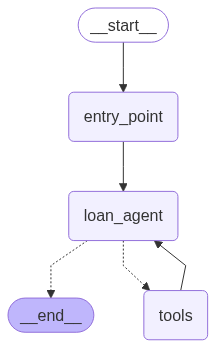

In [39]:
loan_graph = workflow.compile(checkpointer=checkpointer)

display(
  Image(
    loan_graph.get_graph().draw_mermaid_png()
  )
)

## 7 - Executing

In [40]:
customer_query = "I want to have $1000000"

In [41]:
inputs = {
  "customer_query": customer_query,
}

config = {
  "thread_id": 1,
  "customer_name": "Guilherme",
  "age": 26,
  "income": 1000,
  "credit_score": 750,
}

In [42]:
output = loan_graph.invoke(
  input=inputs,
  config=config,
)

Number of messages 1
I want to have $1000000
inside router status: in_progress
inside router status: in_progress
inside router status: lost


## 8 - Inspect

In [43]:
for message in output["messages"]:
  message.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Guilherme- customer_age: 26- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: guilherme

I want to have $1000000
================================== Ai Message ==================================
Name:

In [44]:
output["negotiation_status"]

'lost'

In [45]:
state_history = list(
  loan_graph.get_state_history(
    config={
      "configurable":{"thread_id":1}
    }
  )
)

In [46]:
state_history

[StateSnapshot(values={'messages': [SystemMessage(content="You are a Loan Agent analysing a customer loan request.\n- Understand how much the customer needs.\n- Calculate the maximum loan amount using one of the provided tools.\n- If the requested amount exceeds the limit, update the negotiation to lost.\n- If the requested amount meets the limit, update the negotiation to won.\n- Update status as won or lost based on the negotiation.\nTerminate gracefully:\n  - If won: Notify that a human representative will contact them.\n  - If lost: Thank the customer for their time and explain why the loan was refused.\n\nDetails about the customer you're negotiating with:\n- customer_name: Guilherme- customer_age: 26- customer_income: 1000- customer_credit_score: 750", additional_kwargs={}, response_metadata={}, name='system', id='d5548b02-7258-4c2b-bb2c-6b6622606aa6'), HumanMessage(content='I want to have $1000000', additional_kwargs={}, response_metadata={}, name='guilherme', id='a4409845-a975-

In [47]:
state_history[0].values["messages"][-1].content

'Thank you for your time, Guilherme. Unfortunately, your loan request for $1,000,000 exceeds the maximum amount we can offer, which is $10,000. If you have any other questions or need assistance, feel free to reach out.'

In [48]:
for m in state_history[0].values["messages"]:
  m.pretty_print()

================================ System Message ================================
Name: system

You are a Loan Agent analysing a customer loan request.
- Understand how much the customer needs.
- Calculate the maximum loan amount using one of the provided tools.
- If the requested amount exceeds the limit, update the negotiation to lost.
- If the requested amount meets the limit, update the negotiation to won.
- Update status as won or lost based on the negotiation.
Terminate gracefully:
  - If won: Notify that a human representative will contact them.
  - If lost: Thank the customer for their time and explain why the loan was refused.

Details about the customer you're negotiating with:
- customer_name: Guilherme- customer_age: 26- customer_income: 1000- customer_credit_score: 750
================================ Human Message =================================
Name: guilherme

I want to have $1000000
================================== Ai Message ==================================
Name: